In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import datetime
import random

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('data_test.csv', sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805821 entries, 0 to 805820
Data columns (total 5 columns):
CLIENT_ID             805821 non-null int64
VALUE_DAY             805821 non-null object
DIGITAL_30_CNT        711169 non-null float64
TRAN_ACTIVE_30_CNT    711169 non-null float64
OPER_ACTIVE_30_CNT    711169 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 30.7+ MB


In [4]:
#преобразуем VALUE_DAY из строковой переменной в дату
df['VALUE_DAY'] = df['VALUE_DAY'].astype('datetime64[D]')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805821 entries, 0 to 805820
Data columns (total 5 columns):
CLIENT_ID             805821 non-null int64
VALUE_DAY             805821 non-null datetime64[ns]
DIGITAL_30_CNT        711169 non-null float64
TRAN_ACTIVE_30_CNT    711169 non-null float64
OPER_ACTIVE_30_CNT    711169 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 30.7 MB


## Активные пользователи

In [6]:
df_activ = df.copy()

In [7]:
#группируем пользователей по дате первого отчетного периода (дата, когда пользователь впервые отмечен в отчете) 
first_date = df_activ.groupby('CLIENT_ID')['VALUE_DAY'].min()

In [8]:
first_date

CLIENT_ID
8294         2021-09-30
10609        2021-09-30
15465        2021-09-30
69014        2021-09-30
100397       2021-09-30
                ...    
4294839524   2021-09-30
4294859384   2021-09-30
4294873964   2021-09-30
4294911320   2021-09-30
4294935340   2021-09-30
Name: VALUE_DAY, Length: 169092, dtype: datetime64[ns]

In [9]:
#переименуем название столбца
first_date.name = 'first_date_action'

In [10]:
#добавим полученную разметку к исходному ДФ
df_activ_merge = df_activ.merge(first_date, on='CLIENT_ID')

In [11]:
df_activ_merge.head(10)

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT,first_date_action
0,3596869440,2021-09-30,18.0,8.0,9.0,2021-09-30
1,3596869440,2021-10-31,17.0,13.0,14.0,2021-09-30
2,3596869440,2021-11-30,11.0,9.0,11.0,2021-09-30
3,3596869440,2021-12-31,15.0,13.0,15.0,2021-09-30
4,3596869440,2022-01-31,15.0,11.0,14.0,2021-09-30
5,3596869440,2022-02-28,13.0,11.0,13.0,2021-09-30
6,181778433,2021-09-30,7.0,3.0,3.0,2021-09-30
7,181778433,2021-10-31,7.0,2.0,2.0,2021-09-30
8,181778433,2021-11-30,7.0,3.0,3.0,2021-09-30
9,181778433,2021-12-31,11.0,2.0,2.0,2021-09-30


Из представленных первых 10 строк видно, что некоторые пользователи сохраняют активность на протяжении нескольких месяцев подряд.

In [13]:
#добавим новый столбец, в котором выделим месяц из даты первого попадания в ДФ
df_activ_merge['month_activate'] = df_activ_merge['first_date_action'].astype('datetime64[M]')

In [14]:
#оставим только месяц и год
df_activ_merge['month_activate'] = df_activ_merge['month_activate'].dt.strftime('%Y-%m') 

In [15]:
#оставим только дату (без нулевого времени)
df_activ_merge['VALUE_DAY'] = df_activ_merge['VALUE_DAY'].dt.strftime('%Y-%m-%d') 

In [16]:
#сгруппируем данные для получения когорт, за индекс возьмем месяц первого активного действия пользователя
cohorts_active = df_activ_merge.pivot_table(
    index='month_activate',
    columns='VALUE_DAY',
    values='CLIENT_ID',
    aggfunc='nunique',
) 

In [17]:
cohorts_active

VALUE_DAY,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
month_activate,,,,,,
2021-09,129232.0,124593.0,120232.0,116456.0,105547.0,104163.0
2021-10,NaN,7044.0,6936.0,6883.0,5040.0,4800.0
2021-11,NaN,NaN,5841.0,5743.0,5225.0,4377.0
2021-12,NaN,NaN,NaN,6875.0,6188.0,6170.0
2022-01,NaN,NaN,NaN,NaN,14770.0,14374.0
2022-02,NaN,NaN,NaN,NaN,NaN,5330.0


Отчетливо прослеживается, что с каждым последующим месяцем число пользователей в когортах убывает. 

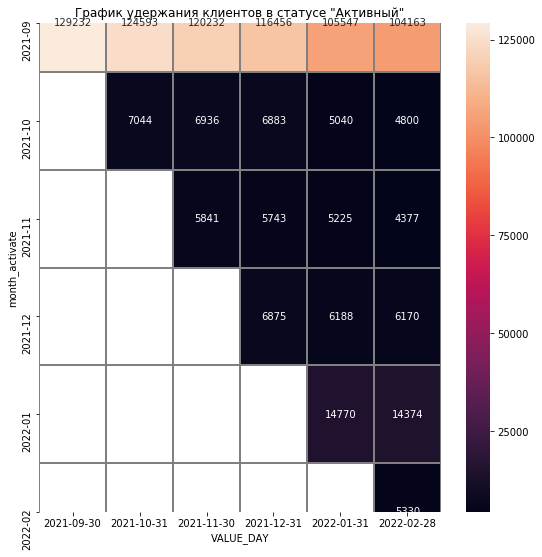

In [18]:
#для визуализации применем тепловую карту
plt.figure(figsize=(9, 9))
plt.title('График удержания клиентов в статусе "Активный"')
sns.heatmap(cohorts_active, annot=True, fmt='.0f', linewidths=1, linecolor='grey') 

## Диджитал Активные пользователи

In [19]:
df1 = df.copy()

In [20]:
dfdf = df1.query('DIGITAL_30_CNT > 0')

In [21]:
df_digital_activ = df1.query('DIGITAL_30_CNT > 0')

In [22]:
#группируем пользователей по дате первого отчетного периода (дата, когда пользователь впервые отмечен в отчете) 
first_date = df_digital_activ.groupby('CLIENT_ID')['VALUE_DAY'].min()

In [23]:
first_date

CLIENT_ID
8294         2021-09-30
10609        2021-09-30
15465        2021-09-30
69014        2021-09-30
100397       2021-09-30
                ...    
4294823638   2021-09-30
4294839524   2021-09-30
4294859384   2021-09-30
4294911320   2021-09-30
4294935340   2021-09-30
Name: VALUE_DAY, Length: 156543, dtype: datetime64[ns]

In [24]:
#переименуем название столбца
first_date.name = 'first_date_action'

In [25]:
#добавим полученную разметку к исходному ДФ
df_digital_activ_merge = df_digital_activ.merge(first_date, on='CLIENT_ID')

In [26]:
df_digital_activ_merge.head(10)

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT,first_date_action
0,3596869440,2021-09-30,18.0,8.0,9.0,2021-09-30
1,3596869440,2021-10-31,17.0,13.0,14.0,2021-09-30
2,3596869440,2021-11-30,11.0,9.0,11.0,2021-09-30
3,3596869440,2021-12-31,15.0,13.0,15.0,2021-09-30
4,3596869440,2022-01-31,15.0,11.0,14.0,2021-09-30
5,3596869440,2022-02-28,13.0,11.0,13.0,2021-09-30
6,181778433,2021-09-30,7.0,3.0,3.0,2021-09-30
7,181778433,2021-10-31,7.0,2.0,2.0,2021-09-30
8,181778433,2021-11-30,7.0,3.0,3.0,2021-09-30
9,181778433,2021-12-31,11.0,2.0,2.0,2021-09-30


In [27]:
#добавим новый столбец, в котором выделим месяц из даты первого попадания в ДФ
df_digital_activ_merge['month_activate'] = df_digital_activ_merge['first_date_action'].astype('datetime64[M]')

In [28]:
#оставим только месяц и год
df_digital_activ_merge['month_activate'] = df_digital_activ_merge['month_activate'].dt.strftime('%Y-%m') 

In [29]:
df_digital_activ_merge['VALUE_DAY'] = df_digital_activ_merge['VALUE_DAY'].dt.strftime('%Y-%m-%d') 

In [30]:
#сгруппируем данные для получения когорт, за индекс возьмем месяц первого активного действия пользователя
cohorts_digital_activ = df_digital_activ_merge.pivot_table(
    index='month_activate',
    columns='VALUE_DAY',
    values='CLIENT_ID',
    aggfunc='nunique',
) 

In [31]:
cohorts_digital_activ

VALUE_DAY,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
month_activate,,,,,,
2021-09,112885.0,105551.0,102781.0,100132.0,90163.0,89532.0
2021-10,NaN,9447.0,7323.0,6991.0,5719.0,5656.0
2021-11,NaN,NaN,6759.0,5397.0,4659.0,4290.0
2021-12,NaN,NaN,NaN,7456.0,5559.0,5367.0
2022-01,NaN,NaN,NaN,NaN,14166.0,13014.0
2022-02,NaN,NaN,NaN,NaN,NaN,5830.0


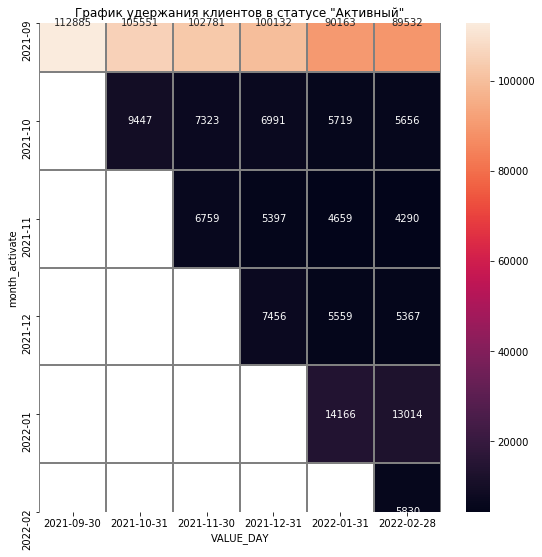

In [32]:
#для визуализации применем тепловую карту
plt.figure(figsize=(9, 9))
plt.title('График удержания клиентов в статусе "Активный"')
sns.heatmap(cohorts_digital_activ, annot=True, fmt='.0f', linewidths=1, linecolor='grey') 